In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import itertools
import os
import gc
import glob
from scipy import stats
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

/home/user/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Tie data from multiple h5 files

In [2]:
foldername = '0066'
start_frame = 200

In [3]:
names = sorted(glob.glob('/media/user/Samsung_T3/Work/Documents/Data/MGrobisData/10-fish/' + foldername + '/' + foldername + '_0*.h5'))

In [4]:
i=0
for name in names:
    f = h5py.File(name, "r")
    group = f['fields/']
    
    n_inds = 30

    vid_id = np.repeat(i, (group['x'].value).shape[0]*(group['x'].value).shape[1]*(group['x'].value).shape[0]).reshape((1,-1))
    frame = (np.repeat(np.tile(np.arange((group['x'].value).shape[1]), n_inds).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_x = (np.repeat((group['x'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    pos_y = (np.repeat((group['y'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    dir_x = (np.repeat((group['heading_x'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    dir_y = (np.repeat((group['heading_y'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    size = (np.repeat((group['body_length'].value).reshape((1,-1)), n_inds)).reshape((1,-1))
    #ang_area_left = (group['ang_area_left_eye'].value).reshape((1,-1))
    #ang_area_right = (group['ang_area_right_eye'].value).reshape((1,-1))
    #ang_pos_left = (group['ang_com_left_eye'].value).reshape((1,-1))
    #ang_pos_right = (group['ang_com_right_eye'].value).reshape((1,-1))
    
    tmp = np.squeeze(np.array([vid_id, frame, pos_x, pos_y, dir_x, dir_y, size])).T
    if i != 0:
        tmp_curr = pd.DataFrame(tmp, columns=['vid_id', 'frame', 'pos_x', 'pos_y', 'dir_x', 'dir_y', 'size'])
        tmp_min = tmp_curr[tmp_curr['frame'] == 0]
        tmp_min = tmp_min.drop_duplicates(subset='pos_x', keep="last")
        tmp_max = tmp_prev[tmp_prev['frame'] == max(tmp_prev['frame'])]
        tmp_max = tmp_max.drop_duplicates(subset='pos_x', keep="last")
        
        last = list(np.array([tmp_max['pos_x'],tmp_max['pos_y']]).T)
        this = list(np.array([tmp_min['pos_x'],tmp_min['pos_y']]).T)
        
        cost = cdist(this,last)
        orig_ids, new_idx = linear_sum_assignment(cost)
        new_ids = tmp_max['f_id'].values[new_idx]
        
        del tmp
        del tmp_prev
        del tmp_min
        del tmp_max
        del cost
        gc.collect()
        
        tmp_curr['f_id'] = np.repeat(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        tmp_curr['n_id'] = np.tile(new_ids, (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        df = pd.concat([df,tmp_curr])
        tmp_prev = tmp_curr
    else:
        fid = np.repeat(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        nid = np.tile(np.arange(n_inds), (group['x'].value).shape[0]*(group['x'].value).shape[1]).reshape((-1,1))
        data = np.hstack((tmp,fid, nid))
        df = pd.DataFrame(data, columns=['vid_id', 'frame', 'pos_x', 'pos_y', 'dir_x', 'dir_y', 'size', 'f_id', 'n_id'])
        tmp_prev = df
    
    i = i+1

print(df.shape[0] - df.dropna().shape[0]) # print number of rows with nas (thish should be 0)

0


In [5]:
#del vid_id
del frame
del pos_x
del pos_y
del dir_x
del dir_y
del size
#del ang_area_left
#del ang_area_right
#del ang_pos_left
#del ang_pos_right
#del df
gc.collect()

14

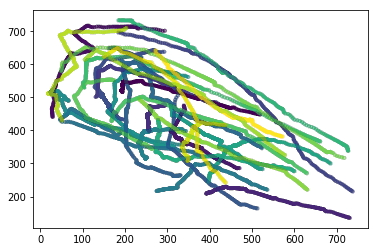

In [6]:
import matplotlib.pyplot as plt

df_plot = df[(df['frame'] < 200) & (df['vid_id'] == 0)]

plt.scatter(df_plot['pos_x'], df_plot['pos_y'], c=df_plot['f_id'].values, s=10, alpha=0.02)
plt.show()

In [7]:
for i in np.unique(df['vid_id']):
    if i != 0:
        df.iloc[np.where(df['vid_id'] == i)[0],1] += (max(df[df['vid_id'] == i-1]['frame']) + 1)
        
df = df[(df['frame'] >= start_frame) & (df['frame'] <= max(df['frame']) - start_frame)]
df['speed'] = 0.0
for idx in np.unique(df['f_id']):
    tmp = df.iloc[np.where(df['f_id'] == idx)[0],:]
    dx = tmp['pos_x'] - tmp['pos_x'].shift(n_inds)
    dy = tmp['pos_y'] - tmp['pos_y'].shift(n_inds)
    df.iloc[np.where(df['f_id'] == idx)[0],9] = np.sqrt(dx**2 + dy**2)
df.head()

,vid_id,frame,pos_x,pos_y,dir_x,dir_y,size,f_id,n_id,speed
8250,0.0,275.0,716.132125,366.375524,0.875647,-0.482952,85.468748,0.0,0.0,NaN
8251,0.0,275.0,716.132125,366.375524,0.875647,-0.482952,85.468748,0.0,1.0,NaN
8252,0.0,275.0,716.132125,366.375524,0.875647,-0.482952,85.468748,0.0,2.0,NaN
8253,0.0,275.0,716.132125,366.375524,0.875647,-0.482952,85.468748,0.0,3.0,NaN
8254,0.0,275.0,716.132125,366.375524,0.875647,-0.482952,85.468748,0.0,4.0,NaN


In [8]:
dcorr = pd.read_csv("/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/golden_shiners/10_fish/" + foldername + '/cross_correlation.csv')
dcorr.columns = ['frame', 'f_id', 'n_id', 'tau', 'cc']

dcorr.iloc[np.where(dcorr['cc'] < np.sqrt(3)/2)[0],4] = 0
dcorr.iloc[np.where(np.abs(dcorr['tau']) <= 5)[0],3] = 0

for fr in np.unique(dcorr['frame']):
    for idx in np.unique(dcorr['f_id']):
        subset_idxs = np.where((dcorr['frame'] == fr) & (dcorr['f_id'] == idx) & (dcorr['tau'] < 0))[0]
        if len(subset_idxs) > 0:
            ccvals = dcorr.iloc[subset_idxs]['cc']
            if max(ccvals > np.sqrt(3)/2):
                max_idx = subset_idxs[np.where(ccvals == max(ccvals))[0]]
                dcorr.iloc[max_idx,4] = 1
    if fr % 1000 == 0:
        print(fr)

dcorr.iloc[(np.where(dcorr['cc'] != 1) or np.where(dcorr['tau'] == 0))[0],4] = 0

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [9]:
df = pd.merge(df, dcorr)

cols = ['frame', 'f_id', 'n_id']
df[cols] = df[cols].astype(np.int32)

df['leader'] = df['cc']

cols = ['vid_id', 'cc', 'tau']
df = df.drop(cols, axis=1)
df.head()

,frame,pos_x,pos_y,dir_x,dir_y,size,f_id,n_id,speed,leader
0,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,1,NaN,0.0
1,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,2,NaN,0.0
2,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,3,NaN,0.0
3,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,4,NaN,0.0
4,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,5,NaN,0.0


In [10]:
tmp = df.loc[:,["frame", "pos_x", "pos_y", "dir_x", "dir_y"]]
tmp_ord = tmp.groupby(['frame']).mean()
tmp_ord = tmp_ord.reset_index()

tmp_ord = tmp_ord.rename(index=str, columns={'pos_x':'centroid_x', 'pos_y':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y'})

In [11]:
df = pd.merge(df, tmp_ord, how='left')
df.head()

,frame,pos_x,pos_y,dir_x,dir_y,size,f_id,n_id,speed,leader,centroid_x,centroid_y,gdir_x,gdir_y
0,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,1,NaN,0.0,707.572816,279.825095,0.854167,-0.440685
1,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,2,NaN,0.0,707.572816,279.825095,0.854167,-0.440685
2,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,3,NaN,0.0,707.572816,279.825095,0.854167,-0.440685
3,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,4,NaN,0.0,707.572816,279.825095,0.854167,-0.440685
4,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,5,NaN,0.0,707.572816,279.825095,0.854167,-0.440685


In [12]:
tmp = df.loc[:,["f_id", "speed"]]

tmp_ord = tmp.groupby(['f_id']).median()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'speed':'ispeed'})

df = pd.merge(df, tmp_ord, how='left')

In [13]:
tmp = df.loc[:,["frame", "speed"]]

tmp_ord = tmp.groupby(['frame']).median()
tmp_ord = tmp_ord.reset_index()
tmp_ord = tmp_ord.rename(index=str, columns={'speed':'gspeed'})

df = pd.merge(df, tmp_ord, how='left')
df.head()

,frame,pos_x,pos_y,dir_x,dir_y,size,f_id,n_id,speed,leader,centroid_x,centroid_y,gdir_x,gdir_y,ispeed,gspeed
0,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,1,NaN,0.0,707.572816,279.825095,0.854167,-0.440685,1.936291,NaN
1,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,2,NaN,0.0,707.572816,279.825095,0.854167,-0.440685,1.936291,NaN
2,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,3,NaN,0.0,707.572816,279.825095,0.854167,-0.440685,1.936291,NaN
3,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,4,NaN,0.0,707.572816,279.825095,0.854167,-0.440685,1.936291,NaN
4,275,716.132125,366.375524,0.875647,-0.482952,85.468748,0,5,NaN,0.0,707.572816,279.825095,0.854167,-0.440685,1.936291,NaN


In [14]:
df.to_csv('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + foldername + '/' + foldername + '.csv', mode='w')